# 🏔️ Assign Molecules 

In [1]:
# Setup colab
try:
    from chromatopy import ChromAnalyzer

except ImportError:
    print("Installing chromatopy...")
    !git clone --quiet -b update-sdrdm https://github.com/FAIRChemistry/chromatopy.git
    %cd chromatopy
    !git checkout update-sdrdm > /dev/null 2>&1
    !pip install . > /dev/null 2>&1
    %cd docs/examples

---

The `ChromAnalyzer` class in the `chromatopy` library provides several methods for adding and defining molecules, that allow later extraction and processing of the data. Information on a molecule is defined in regards of the intend of the measurement. This means that besides a molecule's name, its retention time, also the initial concentration and the respective unit are added for time-course measurements.

Molecules are defined using the `define_molecule` method. It adds a molecule to the list of molecules within the `ChromAnalyzer` object. This method requires several parameters, including the internal identifier, PubChem CID, and retention time, among others.

__Required parameters__:  

- `id`: Internal identifier of the molecule, such as `s0`, `ABTS` or `A0_34S`.
- `pubchem_cid`: PubChem CID of the molecule.
- `retention_time`: Retention time for peak annotation in minutes. If the molecule is not detected in the chromatogram, the retention time can be set to `None`.


__Optional parameters__:  

- `init_conc`: Initial concentration of the molecule. Defaults to `None`
- `conc_unit`: Unit of the concentration. Defaults to `None`.
- `name`: Name of the molecule. If not provided, the name is retrieved from the PubChem database. Defaults to `None`.
- `retention_tolerance`: Retention time tolerance for peak annotation in minutes. Defaults to `0.1`.
- `wavelength`: Wavelength of the detector on which the molecule was detected. Defaults to `None`.

__Returns__:  

- The method returns a `Molecule` object that is added to the `molecules` list within the `ChromAnalyzer` object.

__How it works__:

Once the molecule is defined, all peaks within the chromatographic data that match the retention time within the specified tolerance are annotated with the molecule's `id`, hence allowing for further analysis and processing of the data. This happens in the background. In the following assignment of a substrate and product molecule of a kinetic measurement is shown.

## Kinetic Measurements

### Define Molecules

Consider the following cascade reaction, where molecules measurable by chromatography are highlighted in purple:

![Cascade Reaction Scheme](../../pics/reaction_scheme.png)

This cascade reaction involves two enzymatic steps. In the first step, the Methionine Adenosyltransferase from _Methanocaldococcus jannaschii_ (<i>Mj</i>MAT) catalyzes the conversion of N<sup>6</sup>-benzyl-ATP (`n1_triphosphate`) and <i>ortho</i>-nitrobenzyl-<i>DL</i>-homocysteine (`y_Hcy`) into <i>ortho</i>-Nitrobenzyl-<i>S</>-Adenosylmethionine analogue (`n1y`). In the second step, the Catechol-O-methyltransferase from *Rattus norvegicus* (*RnCOMT*) further processes `n1y` and <i>3,4</i>-dihydroxybenzaldehyde (`DHBAL`) to produce O<sup>3</sup>-modified <i>3,4</i>-dihydroxybenzaldehyde (`DHBAL_modified`) and an <i>S</i>-adenosyl-<i>L</i>-homocysteine analogue.

The following retention times are known:

| Molecule            | Retention Time [min] |
|---------------------|--------------------------|
| `n1_triphosphate`   | 13.9                     |
| `y_Hcy`             | 15.7                     |
| `DHBAL`             | 12.6                     |
| `DHBAL_modified`    | 23.2           |

The `ChromAnalyzer` allows for the annotation of peaks corresponding to these reactants and products. The following code snippet demonstrates how to define the substrates and products for each recorded chromatogram at reaction time points of 0, 0.5, 2, and 6 hours after the reaction start.

In [2]:
from chromatopy import ChromAnalyzer
from chromatopy.units import mM

# Read the data
data_dir = "data/asm"
cascade_analyzer = ChromAnalyzer.read_asm(
    path=data_dir, ph=7.4, temperature=25, mode="timecourse"
)

# Define N6-benzyl-ATP
n1_triphosphate = cascade_analyzer.define_molecule(
    pubchem_cid=127255957,
    id="n1_triphosphate",
    name="N6-benzyl-ATP",
    retention_time=13.9,
    init_conc=2.5,
    conc_unit=mM,
)

# Define ortho-nitrobenzyl-DL-homocysteine
y_Hcy = cascade_analyzer.define_molecule(
    pubchem_cid=-1,
    id="y_Hcy",
    name="ortho-nitrobenzyl-DL-homocysteine",
    retention_time=15.7,
    init_conc=5,
    conc_unit=mM,
)

# Define AdoONB analogue
DHBAL = cascade_analyzer.define_molecule(
    pubchem_cid=8768,
    id="n1y",
    name="DHBAL",
    retention_time=12.6,
    init_conc=0,
    conc_unit=mM,
)

DHBAL_modified = cascade_analyzer.define_molecule(
    pubchem_cid=-1,
    id="DHBAL_O3",
    name="DHBAL O3",
    retention_time=23.21,
    init_conc=0,
    conc_unit=mM,
)

✅ Loaded 4 chromatograms.
🎯 Assigned N6-benzyl-ATP to 4 peaks
🎯 Assigned ortho-nitrobenzyl-DL-homocysteine to 4 peaks
🎯 Assigned DHBAL to 3 peaks
🎯 Assigned DHBAL O3 to 3 peaks


To verify the correct assignment of molecules to their respective peaks, use the `visualize_all` method and setting `assigned_only=True`, ensuring that only the peaks are annotated correctly. If not, and the peaks are for instance shifting, the `retention_tolerance` can be  increased during peak definition to allow for a wider retention time range of be annotated to one molecule.

In [3]:
cascade_analyzer.visualize_all(assigned_only=True, dark_mode=True)

2024-10-25 19:35:45.708 | INFO     | chromatopy.tools.analyzer:visualize_all:1013 - Gaussian peaks are used for visualization, the actual peak shape might differ and is based on the previous preak processing.


### Define Proteins

The `ChromAnalyzer` class also allows to define information on the used catalysts, such as UniProt ID, name, intial concentration and unit along other parameters. In the following example the protein `MjMAT` is added to the `cascade_analyzer` object.

__Required parameters__:
- `id`: Internal identifier of the protein, such as `p0`, `MyProt1`, or `Protein_X`.
- `name`: Name of the protein.
- `init_conc`: Initial concentration of the protein in the sample.
- `conc_unit`: Unit of the concentration, for example, `mM` or `µM`.

__Optional parameters__:
- `sequence`: Amino acid sequence of the protein. This parameter is optional and can be omitted if the sequence is not available. Defaults to `None`.
- `organism`: Name of the organism from which the protein is derived. This is also optional and defaults to `None` if not provided.
- `organism_tax_id`: NCBI taxonomy ID of the organism. This is an optional parameter and can be omitted if the taxonomy ID is not known. Defaults to `None`.
- `constant`: A boolean flag indicating whether the protein concentration is constant throughout the experiment. If set to `True`, the concentration is assumed to remain constant. This parameter defaults to `True`.

In [4]:
cascade_analyzer.define_protein(
    id="MjMAT",
    name="MjMAT",
    init_conc=0.05,
    conc_unit=mM,
)


## Calibration measurements

### External Standard

#### Linear Model

Besides kinetic data, the `ChromAnalyzer` can also be used to analyze calibration measurements and create standards for the quantification of molecules. 
The `add_standard` method adds fits a linear regression to the peaks which are assigned to a molecule and the provided concentrations.

__Required parameters__:
- `molecule`: The molecule for which the standard curve is being generated. This should be an instance of a molecule previously defined in the system.
- `concs`: A list of concentrations at which the standard molecule is measured. For example, `[0.5, 1, 1.5, 2, 2.5, 3]` represents six different concentrations. The order of the concentrations should match the alphabetical order of the imported chromatograms.
- `conc_unit`: The unit of concentration for the specified concentrations.

__Optional parameters__:
- `visualize`: A boolean parameter that, if set to `True`, generates a plot of the standard curve for visualization. This is useful for confirming the accuracy of the calibration process.

__How it works__:
Upon calling the `add_standard` method, the provided concentrations (`concs`) of the `molecule` are used to generate a standard curve through linear regression. The linear relationship between the concentration of $\text{Ana}$ and its peak area is defined by the equation:

$$
A_{\text{Ana}} = a \times C_{\text{Ana}}
$$

Where:
- **$A_{\text{Ana}}$**: Peak area of $\text{Ana}$.
- **$C_{\text{Ana}}$**: Concentration of $\text{Ana}$.
- **$a$**: Slope of the calibration curve, representing the sensitivity or response factor of $\text{Ana}$.

The linear model including information on the valid calibration range is stored in the `standarad` attribute of the `Molecule` object and can later be used for quantification of the molecule from time-course measurements.

In [5]:
from chromatopy import ChromAnalyzer

# Read the data in calibration mode
calib_analyzer = ChromAnalyzer.read_chromeleon(
    path="data/chromeleon",
    ph=7.4,
    temperature=25,
    mode="calibration",
)
# Integrate the chromatograms (only necessary if not done in previous step)
calib_analyzer.process_chromatograms()

# Define adenosine
adenosine = calib_analyzer.define_molecule(
    pubchem_cid=60961,
    id="ADE",
    name="adenosine",
    retention_time=10.9,
    retention_tolerance=0.5,
)

# create a standard
standard = calib_analyzer.add_standard(
    molecule=adenosine,
    visualize=True,
)

Output()

✅ Loaded 6 chromatograms.


🎯 Assigned adenosine to 6 peaks
✅ Models have been successfully fitted.


                                      Model Overview                                       
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD     ┃ Equation ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 84  │ 0.9997    │ 918.2675 │ ADE * a  │ a: 0.3%,                           │
└────────────┴─────┴───────────┴──────────┴──────────┴────────────────────────────────────┘

The standard in now registered to the `adenosine` molecule. And can be added to another `ChromAnalyzer` object to quantify the adenosine concentration in the kinetic measurements.

### Add molecule with a standard to another `ChromAnalyzer`

Once a standard is defined, it can be transferred to another `ChromAnalyzer` object for subsequent quantification of the same molecule. This is carried out using the `add_molecule` method. During this process, the initial concentration and its unit can be adjusted to fit the reaction conditions of the `ChromAnalyzer` with time-course measurements.


In [6]:
from chromatopy import ChromAnalyzer
from chromatopy.units import mM, hour

data_path = "data/chromeleon_kinetic/"
time_course_analyzer = ChromAnalyzer.read_chromeleon(
    path=data_path,
    ph=7.4,
    temperature=25,
    mode="timecourse",
    values=[0, 0, 0, 24, 24, 24],
    unit=hour,
)

time_course_analyzer.process_chromatograms()

# add adenosine with standard to the time course analyzer
time_course_analyzer.add_molecule(
    molecule=adenosine,
    init_conc=0,
    conc_unit=mM,
    retention_tolerance=0.5,
)

Output()

🎯 Assigned adenosine to 3 peaks


### Internal Standard

The `define_internal_standard` method is used to designate a specific molecule as the internal standard within the `ChromAnalyzer` object. This internal standard is essential for accurate concentration calculations during chromatographic analysis. The method requires several parameters, including the molecule's identifier, PubChem CID, and retention time.

__Required parameters__:
- `id`: Internal identifier of the internal standard molecule, such as `s0`, `ABTS`, or `IS_01`.
- `pubchem_cid`: PubChem CID of the internal standard molecule.
- `name`: Name of the internal standard molecule.
- `init_conc`: Initial concentration of the internal standard in the sample.
- `conc_unit`: Unit of the concentration, for example, `mM` or `µM`.
- `retention_time`: Retention time of the internal standard in the chromatogram, measured in minutes.

__Optional parameters__:
- `retention_tolerance`: Retention time tolerance for peak annotation in minutes. This parameter helps account for slight variations in retention time during analysis. Defaults to `0.1`.
- `wavelength`: Wavelength at which the internal standard is detected by the HPLC detector. This is optional and defaults to `None` if not specified.

#### Quantification Using Internal Standard (IS) Ratios

When quantifying an analyte $\text{Ana}$ using an internal standard $\text{IS}$, the concentration of $\text{Ana}$ at a later time point can be calculated by comparing the change in the ratio of their respective peak areas over time. The initial known concentrations and peak areas at time $\text{t=0}$ establish a baseline for this calculation.

The initial peak ratio is defined as:
$$
R_0 = \frac{A_{\text{Ana}_\text{t=0}}}{A_{\text{IS}_\text{t=0}}}
$$

The concentration of $\text{Ana}$ at time \( $\text{t=n}$ \) can be calculated using the following formula:
$$
C_{\text{Ana}_\text{t=n}} = C_{\text{Ana}_\text{t=0}} \times \frac{\left(\frac{A_{\text{Ana}_\text{t=n}}}{A_{\text{IS}_\text{t=n}}}\right)}{R_0}
$$

Where:
- **$R_0$**: The baseline ratio of the peak area of $\text{Ana}$ to $\text{IS}$ at time \( t=0 \).
- **$C_{\text{Ana}_\text{t=0}}$**: Initial concentration of $\text{Ana}$ at reaction time \( t=0 \).
- **$A_{\text{Ana}_\text{t=0}}$**: Peak area of $\text{Ana}$ at reaction time \( t=0 \).
- **$A_{\text{IS}_\text{t=0}}$**: Peak area of the Internal Standard ($\text{IS}$) at reaction time \( t=0 \).
- **$C_{\text{Ana}_\text{t=n}}$**: Concentration of $\text{Ana}$ at time \( t=n \).
- **$A_{\text{Ana}_\text{t=n}}$**: Peak area of $\text{Ana}$ at time \( t=n \).
- **$A_{\text{IS}_\text{t=n}}$**: Peak area of the Internal Standard ($\text{IS}$) at time \( t=n \).

This approach allows the initial concentration of $\text{Ana}$ to be adjusted according to the changes in the ratio of peak areas between the analyte and the internal standard over time, allowing quantification of $\text{Ana}$.

The following example shows how an internal standard molecule is added to the `cascade_analyzer` from the example above:

In [7]:
from chromatopy import ChromAnalyzer
from chromatopy.units import M, minute

path = "data/agilent_csv"
time = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 45, 60]

# Read the data
analyzer_is = ChromAnalyzer.read_agilent(
    path=path,
    ph=7.4,
    temperature=25,
    mode="timecourse",
    values=time,
    unit=minute,
)

# add molecules
analyzer_is.define_molecule(
    id="mal",
    name="maleimide",
    pubchem_cid=10935,
    init_conc=0.656,
    conc_unit=M,
    retention_time=6.05,
)

# define internal standard
analyzer_is.define_internal_standard(
    id="std",
    name="internal standard",
    pubchem_cid=-1,
    init_conc=1.0,
    conc_unit=M,
    retention_time=6.3,
    retention_tolerance=0.05,
)

✅ Loaded 13 chromatograms.
🎯 Assigned maleimide to 13 peaks
🎯 Assigned internal standard to 13 peaks


## Convert Data

Time-course measurements can be converted into the EnzymeML format by using the `to_enzymeml` method. In this process, for all assigned molecules the corresponding peaks are extracted and reorganized as time-course data. If internal oder external standards are defined and `caluculate_concentrations` is set to `True`, the concentrations are calculated for the respective peaks. In the following examples, all previously defined datasets are converted into the EnzymeML format and the time-course data is visualized.

### Cascade Reaction

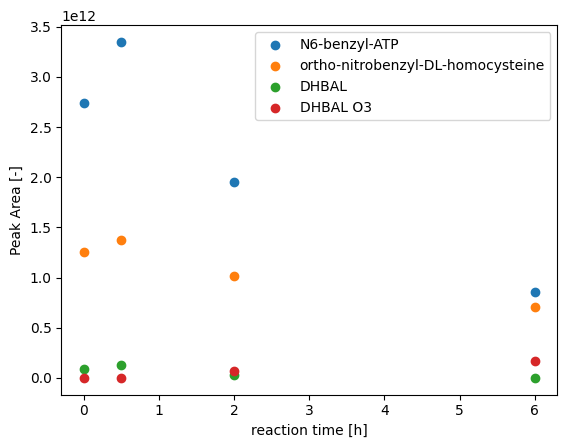

In [8]:
from chromatopy.tools.utility import visualize_enzymeml

cascade_enzymeml = cascade_analyzer.to_enzymeml(
    name="MjMAT cascade",
    calculate_concentration=False,
)

visualize_enzymeml(cascade_enzymeml)

### Adenosine buildup after 24 hours

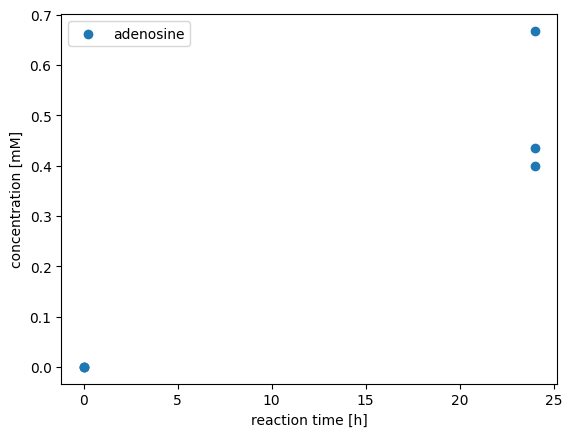

In [9]:
adenosine_enzymeml = time_course_analyzer.to_enzymeml(
    name="adenosine time course",
    calculate_concentration=True,
)


visualize_enzymeml(adenosine_enzymeml)

### Maleimide catalysis with internal standard

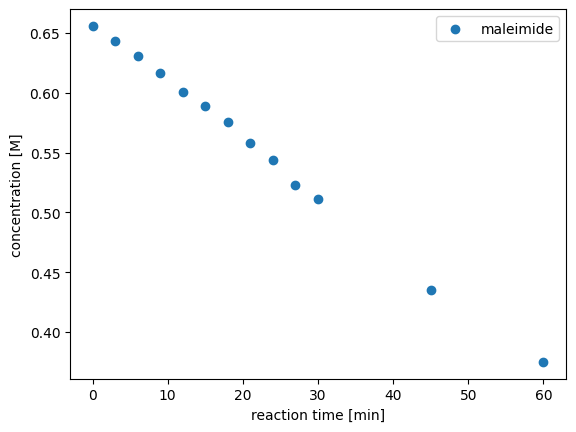

In [10]:
is_enzymeml = analyzer_is.to_enzymeml(
    name="maleimide catalysis",
    calculate_concentration=True,
)

visualize_enzymeml(is_enzymeml)

## Peak detection and integration

In all previous examples, the peaks were already integrated by OpenChrom or other chromatographic software. It is also possible to use the `ChromAnalyzer` to detect and integrate peaks in chromatograms using the [`hplc-py`](https://cremerlab.github.io/hplc-py/index.html) library. Depending on the chromatographic data, the method showed to be unreliable and fails from time to time. Therefore, it is recommended to use the [batch processing with OpenChrom](../../supported_formats/#batch-processing)

The following code shows how the integrated peak processing is done:

In [11]:
calib_analyzer.process_chromatograms(
    prominence=0.03,
)

Output()

🎯 Assigned adenosine to 6 peaks
